# s2rnai summary notebook

The main task we've been working towards is obtaining the motif weight matrix Yijie needs for building a prior network. This will consist of a matrix of (TF, gene) where the values are the conservation scores.   

In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

## Conservation scores: 
We are using precomputed phastcons scores available for download from UCSC.
- What does the distribution of phastcons scores look like on 2L? 
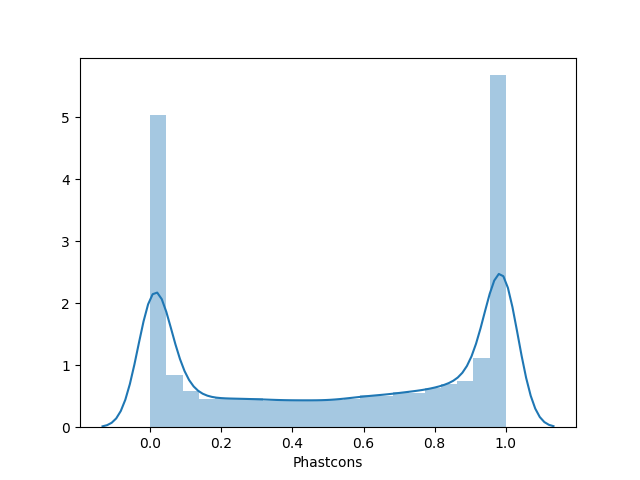

## FIMO: 
We realized that after running fimo, only a few motifs survived q-value thresholding. This led to the large issue of how to deal with multiple testing correction. 

### Is multiple testing killing us?

1. Tried to remedy by re-running fimo with slice and diced fasta file (gene body plus 1kb upstream): 
    * workflow: 
    see the `phastcons_dataprep.sh` in jfear/s2rnai/
     - `fimo2bed.py`  converts fimo output to bed file
     - use `bedtools slop` to add 1 kb upstream
     - `bedtools intersect` motif alignments with slopped gene file
     - Phastcons workflow: 
          * `wig2bed` converts phastCons wigfix file to bed
          * `bedtools intersect` motif/gene intersect with phastcons bed
          * `phastcons_table.py`
             
    * visualized q-val & p-val distributions for the dmmpmm dataset:

### q-value & p-value distribution visualizations: 

In [4]:
table = []
with open('../../data/motif_alignments_dmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            gene = broken[0]
            stuff = (TF, gene, qval, pval)
            table.append(stuff)
df= pd.DataFrame(table, columns=['TF', 'gene', 'qvalue', 'pvalue'])
indexTF = df.set_index(['TF'])
df2 = df[["TF","qvalue","pvalue"]]
groups = df2.groupby(['TF'])

/Users/bergeric/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/bergeric/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


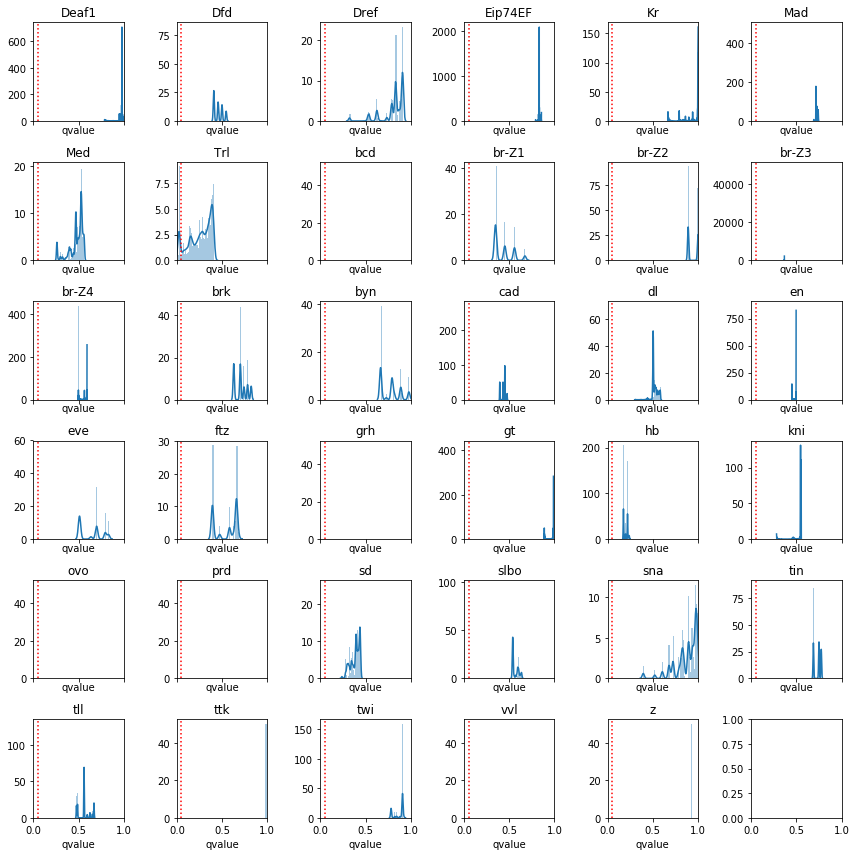

In [5]:
x= groups['qvalue']
fig, axes = plt.subplots(6,6, figsize=(12,12), sharex=True)
for ax, x in zip(axes.flat, x):
    sb.distplot(x[1], ax=ax)
    ax.set_title(x[0])
    ax.axvline(0.05, color='r', ls=':')
ax.set_xlim(0,1)
plt.tight_layout()

/Users/bergeric/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/bergeric/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


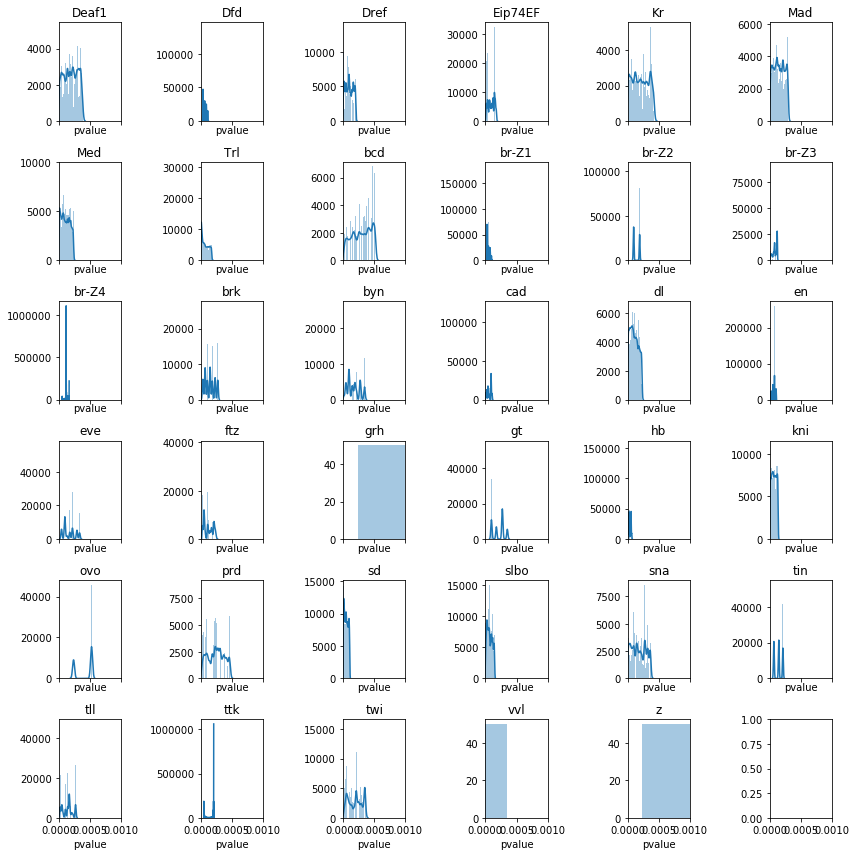

In [6]:
x= groups['pvalue']
fig, axes = plt.subplots(6,6, figsize=(12,12), sharex=True)
for ax, x in zip(axes.flat, x):
    sb.distplot(x[1], ax=ax)
    ax.set_title(x[0])
    ax.axvline(0.05, color='r', ls=':')
ax.set_xlim(0,0.001)
plt.tight_layout()

### q-value filtering settings
How many hits does each TF have if we do not q-value filter? 

In [7]:
grp1 = df.groupby('TF')
grp1.describe()

pvalue                                                            \
           count      mean           std           min       25%       50%   
TF                                                                           
Deaf1    91200.0  0.000194  1.100581e-04  2.230000e-06  0.000097  0.000198   
Dfd      46418.0  0.000060  2.709213e-05  3.230000e-05  0.000032  0.000059   
Dref     50440.0  0.000098  5.993967e-05  1.350000e-06  0.000044  0.000094   
Eip74EF  47294.0  0.000096  4.973941e-05  1.470000e-05  0.000063  0.000104   
Kr       90542.0  0.000208  1.255684e-04  1.350000e-06  0.000101  0.000204   
Mad      95051.0  0.000148  8.568296e-05  9.310000e-08  0.000076  0.000147   
Med      99330.0  0.000109  6.919940e-05  2.270000e-07  0.000049  0.000105   
Trl      99997.0  0.000069  5.420604e-05  1.880000e-08  0.000017  0.000060   
bcd      87925.0  0.000290  1.493215e-04  1.470000e-05  0.000167  0.000303   
br-Z1    33402.0  0.000045  2.295569e-05  2.650000e-05  0.000027  0.000027   
br-Z2    43914.0  0.000139  4.780505e-05  9.660000e-05  0.000097  0.000097   
br-Z3    72541.0  0.000079  3.459087e-05  1.480000e-06  0.000055  0.000078   
br-Z4    62412.0  0.000111  3.348521e-05  5.300000e-05  0.000118  0.000118   
brk      78103.0  0.000140  7.705718e-05  2.960000e-05  0.000066  0.000146   
byn      80670.0  0.000163  9.573234e-05  1.210000e-05  0.000092  0.000142   
cad      51928.0  0.000060  3.269335e-05  7.280000e-06  0.000039  0.000059   
dl       93844.0  0.000107  6.556415e-05  1.680000e-07  0.000052  0.000101   
en       47321.0  0.000065  2.499881e-05  2.180000e-05  0.000048  0.000075   
eve      93966.0  0.000165  9.409968e-05  4.350000e-05  0.000097  0.000132   
ftz      82421.0  0.000120  7.204006e-05  2.180000e-05  0.000048  0.000106   
grh      56134.0  0.000237  1.084212e-19  2.370000e-04  0.000237  0.000237   
gt       82507.0  0.000219  8.920257e-05  9.660000e-05  0.000097  0.000272   
hb       63824.0  0.000035  1.915080e-05  7.280000e-06  0.000022  0.000029   
kni      56085.0  0.000067  3.856016e-05  2.290000e-08  0.000034  0.000067   
ovo      64088.0  0.000419  1.394761e-04  2.370000e-04  0.000237  0.000526   
prd      92679.0  0.000240  1.291927e-04  1.790000e-05  0.000141  0.000249   
sd       53503.0  0.000049  3.118861e-05  8.340000e-08  0.000020  0.000047   
slbo     54201.0  0.000069  4.181253e-05  9.090000e-07  0.000032  0.000063   
sna      87999.0  0.000179  1.115768e-04  2.720000e-06  0.000077  0.000170   
tin      64412.0  0.000135  5.795470e-05  6.510000e-05  0.000065  0.000144   
tll      94294.0  0.000141  7.821385e-05  2.180000e-05  0.000066  0.000168   
ttk      49970.0  0.000172  6.368468e-05  4.390000e-05  0.000204  0.000204   
twi      93186.0  0.000191  1.084660e-04  1.790000e-05  0.000087  0.000209   
vvl      38083.0  0.000352  5.421082e-20  3.520000e-04  0.000352  0.000352   
z        61658.0  0.000237  1.084211e-19  2.370000e-04  0.000237  0.000237   

                              qvalue                                         \
              75%       max    count      mean           std     min    25%   
TF                                                                            
Deaf1    0.000290  0.000387  91200.0  0.968581  4.096314e-02  0.7870  0.980   
Dfd      0.000085  0.000107  46418.0  0.457459  4.850480e-02  0.4080  0.408   
Dref     0.000158  0.000199  50440.0  0.812940  1.229978e-01  0.3210  0.794   
Eip74EF  0.000144  0.000173  47294.0  0.828811  1.358638e-02  0.7910  0.832   
Kr       0.000317  0.000428  90542.0  0.973808  5.993782e-02  0.6660  0.995   
Mad      0.000219  0.000297  95051.0  0.724356  1.122301e-02  0.6930  0.716   
Med      0.000169  0.000236  99330.0  0.480360  7.607670e-02  0.2610  0.464   
Trl      0.000115  0.000172  99997.0  0.256381  1.217662e-01  0.0115  0.160   
bcd      0.000411  0.000510  87925.0  1.000000  0.000000e+00  1.0000  1.000   
br-Z1    0.000075  0.000097  33402.0  0.431065  1.031724e-01  0.3480  0.348   
br-Z2    0.000193 

### fimo with priors: 
   * used the `create-priors` function from MEME suite (sequences in the phastcons file need to be a subset of the fasta file sequences, and in the same order, so I had to trim and reorder the files)
   * observed that the p-val distributions from the new fimo were almost identical to that of the earlier run

In [ ]:
#remove unneeded chrom
IN_GOODCHROM = False
#goodchrom_vals = []
with open('../../data/phastcon_trim.wig', 'w+') as outfile:
    with open('../../data/dm6.27way.phastCons.wigFix') as p: 
        for line in p: 
            if line.startswith('fixedStep'):
                chrom = line.split()[1].split('=')[1]
                if '_' not in chrom: 
                    IN_GOODCHROM = True
                    outfile.write(line)
                if '_' in chrom:
                    IN_GOODCHROM = False
            else: 
                if IN_GOODCHROM:
                    outfile.write(line)

In [ ]:
#put fasta file in wig order
IN_GOODCHROM = False
IN_XY = False
xylist = []
fastalist =[]
with open('../../data/dmel_r6-11_trim.fasta', 'w+') as outfile:
    with open('../../data/dmel_r6-11.fasta') as f:
        for line in f: 
            if line.startswith('>'):
                chrom = line.split()[0].split('>')[1]
                if chrom in chromlist:
                    if chrom == 'chrX' or chrom == 'chrY': 
                        IN_XY = True 
                        IN_GOODCHROME = False
                        xylist.append(line)
                    else: 
                        IN_GOODCHROM = True
                        IN_XY = False
                        fastalist.append(line)
                else:
                    IN_GOODCHROM = False
                    IN_XY = False
            else: 
                if IN_GOODCHROM:
                    fastalist.append(line)
                if IN_XY: 
                    xylist.append(line)
    fastalist.append(xylist)
    for item in fastalist: 
        outfile.writelines(item)

In [ ]:
#for fimo run with priors: 
table = []
with open('../../data/fimo_out/fimo.gff') as f:
    for line in f:  
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            qval = float(broken[8].split(';')[4].strip()[7:])
            pval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:].split('_')[0]
            gene = broken[0]
            stuff = (TF, gene, qval, pval)
            table.append(stuff)           
df= pd.DataFrame(table, columns=['TF','gene', 'q-value', 'p-value'])
df.head()
indexTF = df.set_index(['TF'])
df2 = df[["TF","q-value","p-value"]]
df3 = df[['TF', 'gene', 'p-value']]
groups = df2.groupby(['TF'])
x= groups['p-value']
fig, axes = plt.subplots(6,6, figsize=(10,10), sharex=True)
for ax, x in zip(axes.flat, x):
    sb.distplot(np.log10(x[1]), ax=ax)
    ax.set_title(x[0])
plt.tight_layout()

### Rank Analysis: 

In [13]:
#the following analysis was performed on each of the five motif datasets
#Using flyReg: 
table = []
with open('../../data/fimo/motif_alignments_flyReg_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            gene = broken[0]
            start = broken[3]
            stop = broken[4]
            stuff = (TF, TF, gene, start, stop, qval, pval)
            table.append(stuff)
            
flyReg_df= pd.DataFrame(table, columns=['motif_id', 'motif_symbol','target_gene','start','stop','qvalue', 'pvalue'])

In [15]:
#add column for motif_FBgn
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',') 
reg1 = flyReg_df.merge(symbolmap, left_on='motif_id', right_on='SYMBOL', how='left')
reg1 = reg1.rename(columns={'ENSEMBL': 'motif_FBgn'})
regtrim = reg1[['motif_id','motif_FBgn','motif_symbol','target_gene','start','stop','pvalue']]
#collapse on start/stop and get min p value, # hits 
regtrim['hits'] = 0
regtrim2 = regtrim.groupby(['motif_id','motif_FBgn','motif_symbol','target_gene'])
regagg = regtrim2.agg({'pvalue': ['min'], 'hits': 'count'})
regagg.columns = ['min_pval','#hits'] 
reg = regagg.reset_index()
reg['source'] = 'flyReg'
reg.head()

/Users/bergeric/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,motif_id,motif_FBgn,motif_symbol,target_gene,min_pval,#hits,source
0,Abd-B,FBgn0000015,Abd-B,FBgn0000008,0.000027,28,flyReg
1,Abd-B,FBgn0000015,Abd-B,FBgn0000014,0.000027,20,flyReg
2,Abd-B,FBgn0000015,Abd-B,FBgn0000015,0.000027,68,flyReg
3,Abd-B,FBgn0000015,Abd-B,FBgn0000017,0.000027,24,flyReg
4,Abd-B,FBgn0000015,Abd-B,FBgn0000018,0.000171,3,flyReg


The five resulting tables were concatenated to obtain the following master table:

In [17]:
#big concatenated table
bigtable = pd.read_table('../../output/concat.txt', index_col=0)
bigtable.head()

/Users/bergeric/miniconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,motif_id,motif_FBgn,motif_symbol,target_gene,#hits,min_pval,source
0,Deaf1,FBgn0013799,Deaf1,FBgn0000003,2,0.000323,dmmpmm
1,Deaf1,FBgn0013799,Deaf1,FBgn0000008,26,0.000010,dmmpmm
2,Deaf1,FBgn0013799,Deaf1,FBgn0000014,21,0.000026,dmmpmm
3,Deaf1,FBgn0013799,Deaf1,FBgn0000015,42,0.000024,dmmpmm
4,Deaf1,FBgn0013799,Deaf1,FBgn0000017,25,0.000033,dmmpmm


Clean up, collapse, and work with big table: 

First collapse over motif: 

In [18]:
bigtable['motif_hits'] = 0
grp=bigtable.groupby(['motif_FBgn','target_gene','source','#hits'])
agg=grp.agg({'min_pval': ['min'], 'motif_hits': 'count'})
agg.columns = ['min_pval', 'motif_hits'] 
agg2 = agg.reset_index()
agg2.columns = ['motif_FBgn','target_gene','source','pos_hits','min_pval', 'motif_hits']
agg2.head()

,motif_FBgn,target_gene,source,pos_hits,min_pval,motif_hits
0,FBgn0000014,FBgn0000003,flyReg,1,1,0.000027
1,FBgn0000014,FBgn0000003,onTheFly,1,2,0.000022
2,FBgn0000014,FBgn0000008,flyFactor,26,1,0.000118
3,FBgn0000014,FBgn0000008,flyReg,21,1,0.000027
4,FBgn0000014,FBgn0000008,idmmpmm,26,1,0.000027


Then collapse over database: 

In [19]:
grp2 = agg2.groupby(['motif_FBgn','target_gene'])
agg3 = grp2.agg({'min_pval':['min'], 'pos_hits':['sum'],'motif_hits':['sum']})
agg3.columns = ['min_pval', 'sum_motif_hits', 'sum_pos_hits'] 
agg4 = agg3.reset_index()
#add column for motif_symbol
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',', na_values='NA', keep_default_na=False) 
newmap = symbolmap.drop_duplicates(subset='ENSEMBL', keep='first')
update = agg4.merge(newmap, left_on='motif_FBgn', right_on='ENSEMBL', how='left')
update = update.rename(columns={'SYMBOL': 'motif_symbol'})
trim = update[['motif_FBgn','motif_symbol','target_gene','min_pval','sum_motif_hits','sum_pos_hits']].copy()
#add column for gene_symbol
update2 = trim.merge(newmap, left_on='target_gene', right_on='ENSEMBL', how='left')
update2 = update2.rename(columns={'SYMBOL': 'gene_symbol'})
trim2 = update2[['motif_FBgn','motif_symbol','target_gene','gene_symbol','min_pval','sum_motif_hits','sum_pos_hits']].copy()

In [ ]:
#create matrix: 
matrix = trim2[['motif_FBgn','target_gene','min_pval']]
matrix.set_index(['target_gene','motif_FBgn'], inplace=True)
matrix.unstack()

### Other answered questions: 

How many motifs are there per gene?

In [20]:
trim2.groupby(['target_gene']).agg({'sum_motif_hits':['count']}).describe()

,sum_motif_hits
,count
count,17659.000000
mean,264.822810
std,265.228333
min,13.000000
25%,216.000000
50%,247.000000
75%,283.000000
max,5681.000000


How many unique TF motifs do we have?

In [21]:
len(trim2.motif_FBgn.unique())

299

### Slice and dice using conservation scores surrounding TSS

In [23]:
import gffutils
import pybedtools
from gffutils import pybedtools_integration

In [24]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

/Users/bergeric/miniconda3/lib/python3.5/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [ ]:
x = pybedtools_integration.tsses(db, merge_overlapping=True)
x.moveto('../../output/dm6tsses.bed')

Can use the following commands to make heatmaps/plot profiles in `deepTools`: 
```
computeMatrix reference-point --referencePoint TSS -b 1000 -a 1000 -R dm6tsses.bed -S ../data/dm6.27way.phastCons.bw -o matrix3_dm6_phastTSS.gz
plotHeatmap -m matrix3_dm6_phastTSS.gz -out heatmap3_dm6_phastTSS.png
plotProfile -m matrix3_yp2_phastTSS.gz -out yp2_profileplot3.png
```

Heatmap of scores centered on TSS: 
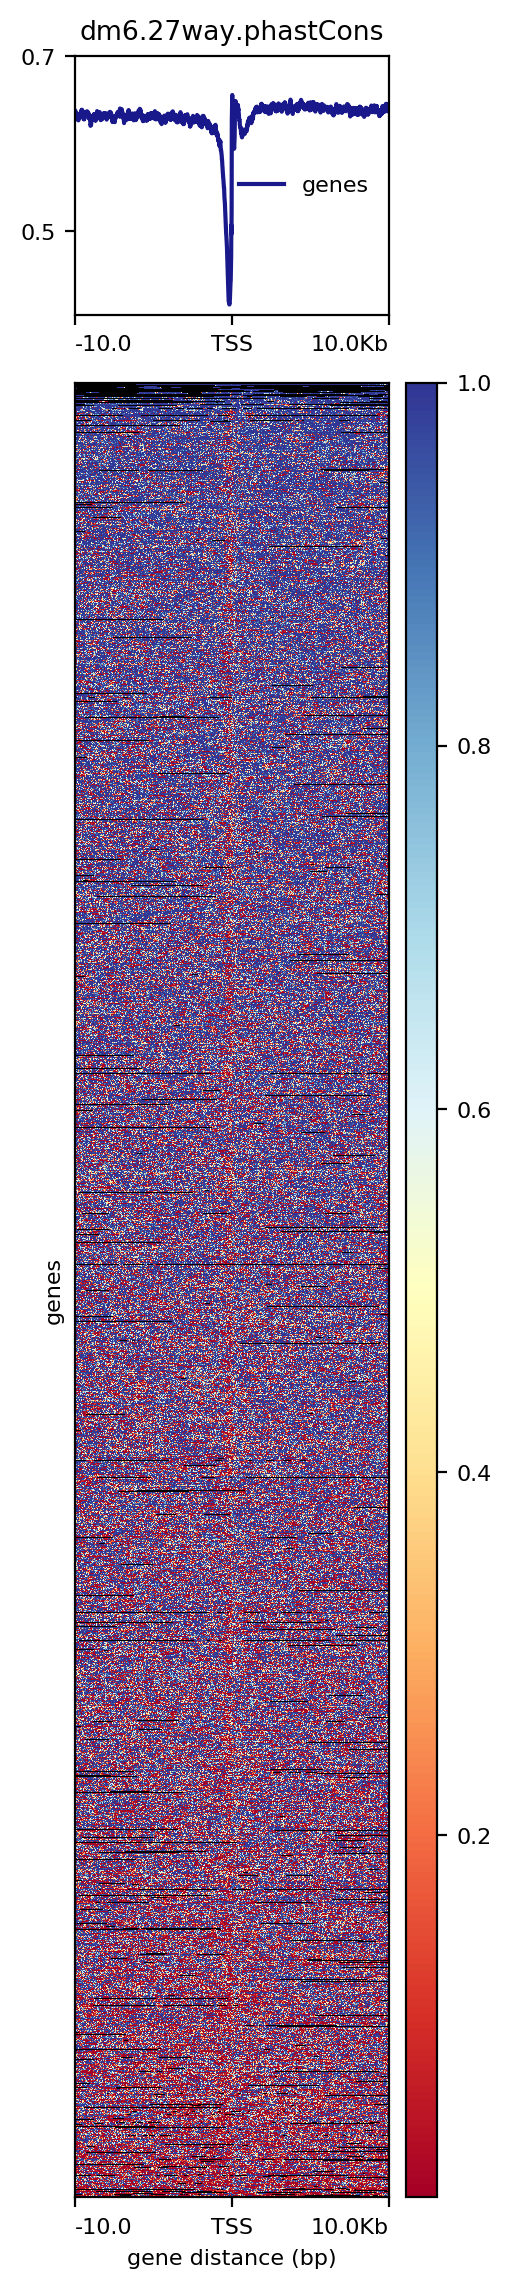

### How many transcripts per gene? 

In [25]:
#number of transcripts per gene
table1 = []
for gene in db.features_of_type('gene'): 
    name = gene.id
    transcript = db.children(gene, featuretype='transcript')
    transcriptnum = len(list(transcript))
    row = [name, transcriptnum]
    table1.append(row)
df1 = pd.DataFrame(table1, columns=['gene','#transcripts'])

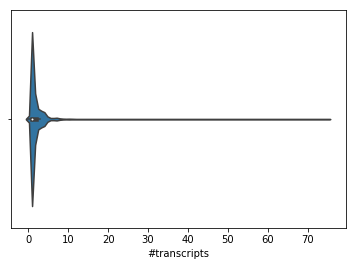

In [26]:
sb.violinplot(df1['#transcripts'])